# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

# Load data

In [58]:
df = pd.read_excel("dataset/data_pip_cleaned.xlsx")
df.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,Sepeda motor,Wirausaha,4213001,1,Tidak,Tidak,Tidak Layak
1,Jalan kaki,Lainnya,3249958,Lebih dari 3,Tidak,Tidak,Layak
2,Lainnya,Peternak,4166323,2,Tidak,Tidak,Tidak Layak
3,Sepeda motor,Lainnya,3261966,2,Tidak,Tidak,Layak
4,Sepeda motor,Wirausaha,3254943,Lebih dari 3,Tidak,Tidak,Layak


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Alat Transportasi      1000 non-null   object
 1   Pekerjaan Orang Tua    1000 non-null   object
 2   Penghasilan Orang Tua  1000 non-null   int64 
 3   Jumlah Tanggungan      1000 non-null   object
 4   Pemilik KIP            1000 non-null   object
 5   Pemilik KPS            1000 non-null   object
 6   Status                 1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


# Preprocessing Data

Mengelompokkan data penghasilan orang tua : rendah, sedang, tinggi

In [60]:
df_binning = df.copy()

Membuat Fungsi kategori penghasilan

In [5]:
def kategori_penghasilan(nilai):
    if nilai <= 1500000:
        return 'Rendah'
    elif nilai <= 3000000:
        return 'Sedang'
    else:
        return 'Tinggi'

In [62]:
df_binning['Penghasilan Orang Tua'] = df['Penghasilan Orang Tua'].apply(kategori_penghasilan)

cek = pd.DataFrame({
    'Penghasilan Orang Tua': df['Penghasilan Orang Tua'],
    'Kategori': df_binning['Penghasilan Orang Tua']
})

Manampilkan Plot jumlah masing-masing kategori

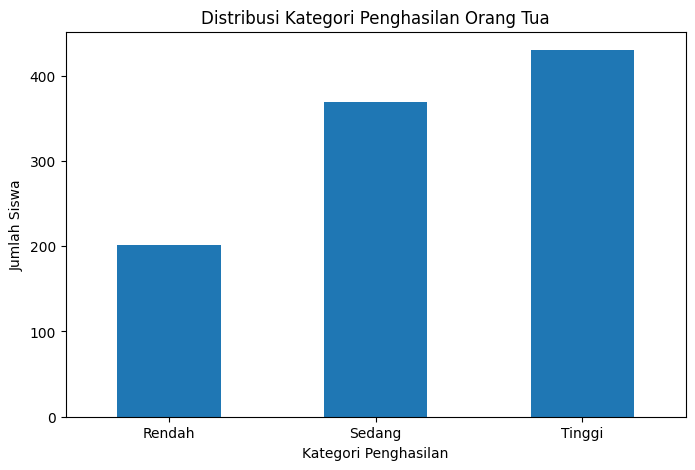

In [63]:
counts = df_binning['Penghasilan Orang Tua'].value_counts().sort_index()

plt.figure(figsize=(8,5))
counts.plot(kind='bar')
plt.title('Distribusi Kategori Penghasilan Orang Tua')
plt.xlabel('Kategori Penghasilan')
plt.ylabel('Jumlah Siswa')
plt.xticks(rotation=0)
plt.show()


Menampilkan nilai Unik tiap kolom

In [64]:
for col in df_binning.columns:
    unique_vals = df_binning[col].unique()
    print(f"Kolom '{col}' memiliki nilai unik sebanyak {len(unique_vals)}:")
    print(unique_vals)
    print('-' * 40)

Kolom 'Alat Transportasi' memiliki nilai unik sebanyak 3:
['Sepeda motor' 'Jalan kaki' 'Lainnya']
----------------------------------------
Kolom 'Pekerjaan Orang Tua' memiliki nilai unik sebanyak 5:
['Wirausaha' 'Lainnya' 'Peternak' 'Petani' 'Buruh']
----------------------------------------
Kolom 'Penghasilan Orang Tua' memiliki nilai unik sebanyak 3:
['Tinggi' 'Sedang' 'Rendah']
----------------------------------------
Kolom 'Jumlah Tanggungan' memiliki nilai unik sebanyak 4:
['1' 'Lebih dari 3' '2' '3']
----------------------------------------
Kolom 'Pemilik KIP' memiliki nilai unik sebanyak 2:
['Tidak' 'Ya']
----------------------------------------
Kolom 'Pemilik KPS' memiliki nilai unik sebanyak 2:
['Tidak' 'Ya']
----------------------------------------
Kolom 'Status' memiliki nilai unik sebanyak 2:
['Tidak Layak' 'Layak']
----------------------------------------


Mapping kolom Status Layak: 1, Tidak Layak: 0

In [65]:
df = df_binning.copy()
mapping = {'Layak': 1, 'Tidak Layak': 0}
df['Status'] = df['Status'].map(mapping)
df.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,Sepeda motor,Wirausaha,Tinggi,1,Tidak,Tidak,0
1,Jalan kaki,Lainnya,Tinggi,Lebih dari 3,Tidak,Tidak,1
2,Lainnya,Peternak,Tinggi,2,Tidak,Tidak,0
3,Sepeda motor,Lainnya,Tinggi,2,Tidak,Tidak,1
4,Sepeda motor,Wirausaha,Tinggi,Lebih dari 3,Tidak,Tidak,1


Meng Encode Kolom Kategori

In [6]:
def fit_label_encoders(unique_values):
    label_encoders = {}
    for col, classes in unique_values.items():
        le = LabelEncoder()
        le.fit(classes)
        label_encoders[col] = le
    return label_encoders

def transform_df(df, label_encoders):
    df_encoded = df.copy()
    for col, le in label_encoders.items():
        if col in df_encoded.columns:
            # Pastikan nilai di df ada dalam kelas yang sudah fit
            unknown_mask = ~df_encoded[col].isin(le.classes_)
            if unknown_mask.any():
                raise ValueError(
                    f"Kolom '{col}' mengandung kategori yang tidak dikenal: "
                    f"{df_encoded.loc[unknown_mask, col].unique()}"
                )
            df_encoded[col] = le.transform(df_encoded[col])
    return df_encoded

unique_values = {
    'Alat Transportasi': ['Jalan kaki', 'Sepeda motor', 'Lainnya'],
    'Pekerjaan Orang Tua': ['Wirausaha', 'Lainnya', 'Peternak', 'Petani', 'Buruh'],
    'Penghasilan Orang Tua': ['Tinggi', 'Sedang', 'Rendah'],
    'Jumlah Tanggungan': ['1', 'Lebih dari 3', '2', '3'],
    'Pemilik KIP': ['Tidak', 'Ya'],
    'Pemilik KPS': ['Tidak', 'Ya']
}

# Fit encoder (sekali untuk kelas lengkap)
label_encoders = fit_label_encoders(unique_values)

In [67]:
df_encoded = transform_df(df, label_encoders)
df_encoded.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,2,4,2,0,0,0,0
1,0,1,2,3,0,0,1
2,1,3,2,1,0,0,0
3,2,1,2,1,0,0,1
4,2,4,2,3,0,0,1


## Spliting data

In [68]:
X = df_encoded.drop(columns=['Status'])
y = df_encoded['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (800, 6)
X_test shape: (200, 6)
y_train shape: (800,)
y_test shape: (200,)


## Model Development dengan Artificial Neural Network (ANN)

Build model ANN

In [69]:
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_ann.compile(optimizer= Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_ann.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                448       
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4673 (18.25 KB)
Trainable params: 4673 (18.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Callback

In [70]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training Model

In [71]:
# Train model
history_ann = model_ann.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.6922 - val_loss: 0.5034 - val_accuracy: 0.7688
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4633 - accuracy: 0.7906 - val_loss: 0.4439 - val_accuracy: 0.7750
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.7984 - val_loss: 0.3935 - val_accuracy: 0.7563
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.3808 - accuracy: 0.8234 - val_loss: 0.3627 - val_accuracy: 0.7750
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8328 - val_loss: 0.3310 - val_accuracy: 0.8375
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.3334 - accuracy: 0.8203 - val_loss: 0.3167 - val_accuracy: 0.8188
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2960 - accuracy: 0.8484 - val_loss: 0.3001 - val_accuracy: 0.8062
Epoch 8/50
40/40 [==

Menampilkan Plot training history dari accuracy dan loss

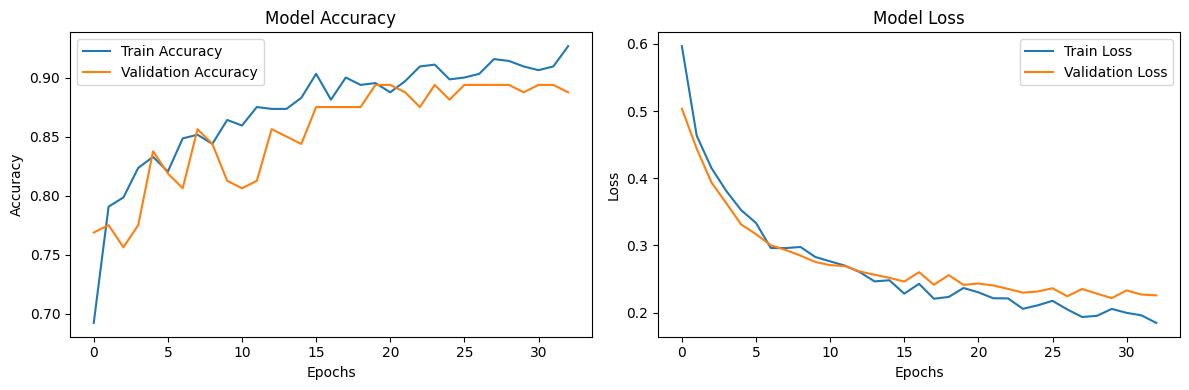

In [72]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Evaluasi model

In [73]:
loss, accuracy = model_ann.evaluate(X_test, y_test)
loss_train, accuracy_train = model_ann.evaluate(X_train, y_train)


print("=====================================")
print("Hasil Evaluasi model ANN")
print("=====================================")
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")
print("=====================================")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Loss: {loss_train}")


25/25 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9162
Hasil Evaluasi model ANN
Test Accuracy: 0.8949999809265137
Test Loss: 0.22164025902748108
Train Accuracy: 0.9162499904632568
Train Loss: 0.18064682185649872


Menampilkan Confusion matrix

7/7 [==============================] - 0s 1ms/step


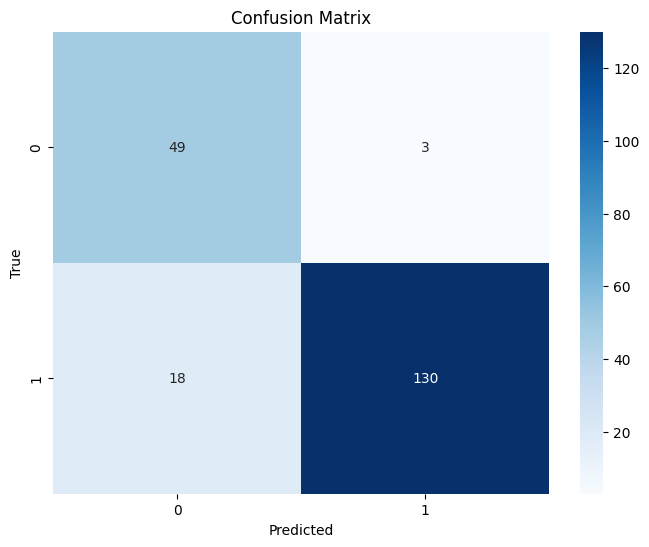

In [74]:
y_pred_ann = model_ann.predict(X_test)
y_pred_ann = (y_pred_ann > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Menampilkan classification report

In [75]:
print(classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        52
           1       0.98      0.88      0.93       148

    accuracy                           0.90       200
   macro avg       0.85      0.91      0.87       200
weighted avg       0.91      0.90      0.90       200



Menyimpan bobot model ke file HDF5

In [76]:
# model_ann.save("model/model_ann.h5")

### Evaluasi pada 10 data actual berlabel

### Load Model

In [2]:
model = load_model('model/model_ann.h5')

Load data

In [9]:
df_label = pd.read_excel('data_test/data_actual.xlsx')

Data Preprocessing

In [10]:
df_pred = df_label.drop(columns=['Status','Nama'])
df_pred['Penghasilan Orang Tua'] = df_pred['Penghasilan Orang Tua'].apply(kategori_penghasilan)
df_pred.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS
0,Jalan kaki,Wirausaha,Tinggi,1,Tidak,Tidak
1,Sepeda motor,Lainnya,Tinggi,Lebih dari 3,Tidak,Tidak
2,Jalan kaki,Peternak,Tinggi,2,Tidak,Tidak
3,Jalan kaki,Lainnya,Tinggi,2,Tidak,Tidak
4,Sepeda motor,Wirausaha,Tinggi,Lebih dari 3,Tidak,Tidak


In [11]:
df_pred = transform_df(df_pred, label_encoders)
df_pred.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS
0,0,4,2,0,0,0
1,2,1,2,3,0,0
2,0,3,2,1,0,0
3,0,1,2,1,0,0
4,2,4,2,3,0,0


Melakukan prediksi pada data

In [81]:
y_pred_probs = model.predict(df_pred)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

label_mapping = {0: 'Tidak Layak', 1: 'Layak'}

df_label['Status_Pred'] = [label_mapping[p] for p in y_pred]

print("Hasil Prediksi Model pada data baru:")
prediksi = pd.DataFrame({
    'Status_actual': df_label['Status'],
    'Status_pred': df_label['Status_Pred']
})

print(prediksi)

y_true_numeric = df_label['Status'].map({'Layak': 1, 'Tidak Layak': 0})
report = classification_report(y_true_numeric, y_pred, target_names=['Tidak Layak', 'Layak'])

print("============================")
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 49ms/step
Hasil Prediksi Model pada data baru:
  Status_actual  Status_pred
0   Tidak Layak  Tidak Layak
1         Layak        Layak
2   Tidak Layak  Tidak Layak
3         Layak  Tidak Layak
4         Layak        Layak
5   Tidak Layak  Tidak Layak
6         Layak        Layak
7         Layak        Layak
8   Tidak Layak  Tidak Layak
9   Tidak Layak  Tidak Layak
Classification Report:
              precision    recall  f1-score   support

 Tidak Layak       0.83      1.00      0.91         5
       Layak       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



Insight: Berdasarkan hasil prediksi, model menunjukkan akurasi 90% dalam memprediksi status kelayakan, dengan precision tinggi pada kedua kategori ('Tidak Layak' dan 'Layak'), namun recall untuk kategori 'Layak' masih dapat diperbaiki.

## Inference

Load Data test

In [13]:
df_test = pd.read_excel('data_test/data_10baris.xlsx')
df_test = df_test.copy().drop(columns='Nama')
df_test.head()

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS
0,Jalan kaki,Wirausaha,4213001,1,Tidak,Tidak
1,Sepeda motor,Lainnya,3249958,Lebih dari 3,Tidak,Tidak
2,Jalan kaki,Peternak,4166323,2,Tidak,Tidak
3,Jalan kaki,Lainnya,3261966,2,Tidak,Tidak
4,Sepeda motor,Wirausaha,3254943,Lebih dari 3,Tidak,Tidak


### Data preprocessing

In [83]:
df_test['Penghasilan Orang Tua'] = df_test['Penghasilan Orang Tua'].apply(kategori_penghasilan)
df_test.head()


,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS
0,Jalan kaki,Wirausaha,Tinggi,1,Tidak,Tidak
1,Sepeda motor,Lainnya,Tinggi,Lebih dari 3,Tidak,Tidak
2,Jalan kaki,Peternak,Tinggi,2,Tidak,Tidak
3,Jalan kaki,Lainnya,Tinggi,2,Tidak,Tidak
4,Sepeda motor,Wirausaha,Tinggi,Lebih dari 3,Tidak,Tidak


In [84]:
df_test = transform_df(df_test, label_encoders)
df_test.head(6)

,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS
0,0,4,2,0,0,0
1,2,1,2,3,0,0
2,0,3,2,1,0,0
3,0,1,2,1,0,0
4,2,4,2,3,0,0
5,2,4,2,0,1,1


Melakukan prediksi pada data baru

In [66]:
y_pred_probs = model.predict(df_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

label_mapping = {0: 'Tidak Layak', 1: 'Layak'}

df_actual = pd.read_excel('data_test/data_10baris.xlsx')
df_actual['Status'] = [label_mapping[p] for p in y_pred]

print("Hasil Prediksi Model pada data baru:")
df_actual.head(10)

1/1 [==============================] - 0s 19ms/step
Hasil Prediksi Model pada data baru:


,Alat Transportasi,Pekerjaan Orang Tua,Penghasilan Orang Tua,Jumlah Tanggungan,Pemilik KIP,Pemilik KPS,Status
0,Jalan kaki,Wirausaha,4213001,1,Tidak,Tidak,Tidak Layak
1,Sepeda motor,Lainnya,3249958,Lebih dari 3,Tidak,Tidak,Layak
2,Jalan kaki,Peternak,4166323,2,Tidak,Tidak,Tidak Layak
3,Jalan kaki,Lainnya,3261966,2,Tidak,Tidak,Tidak Layak
4,Sepeda motor,Wirausaha,3254943,Lebih dari 3,Tidak,Tidak,Layak
5,Sepeda motor,Wirausaha,3500000,1,Ya,Ya,Layak
6,Jalan kaki,Petani,3100000,2,Tidak,Tidak,Tidak Layak
7,Sepeda motor,Petani,3200000,Lebih dari 3,Ya,Ya,Layak
8,Jalan kaki,Wirausaha,4000000,1,Tidak,Tidak,Tidak Layak
9,Sepeda motor,Peternak,3300000,2,Ya,Ya,Layak


Menyimpan model dalam bentuk JSON melalui Google Colab

In [67]:
# import subprocess

# subprocess.run([
#     "tensorflowjs_converter",  
#     "--input_format", "keras",
#     "/content/sample_data/model_ann.h5",  
#     "/content/sample_data/model_tfjs"     
# ])